In [1]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
import torch, torchvision, os, cv2
from torch.utils.data import random_split, Dataset
from torch.nn import Tanh, Linear, ReLU, Sequential, Conv2d, MaxPool2d, Sigmoid, BatchNorm2d, Flatten, ConvTranspose2d
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class augementData(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

def saveRes2Img(inputs, labels, outputs):
    inputsNP = inputs.cpu().data.numpy()
    labelsNP = labels.cpu().data.numpy()
    outputsNP = outputs.cpu().data.numpy()
    rowN = 15
    for n in range(len(inputsNP)):
        ture_l = np.array(inputsNP[n,0,:,:])
        ture_a = np.array(labelsNP[n,0,:,:])
        ture_b = np.array(labelsNP[n,1,:,:])
        pred_a = np.array(outputsNP[n,0,:,:])
        pred_b = np.array(outputsNP[n,1,:,:])
        ture_LAB = np.array([ture_l,ture_a,ture_b])
        ture_LAB = ture_LAB*255
        pred_LAB = np.array([ture_l,pred_a,pred_b])
        pred_LAB = pred_LAB*255
        ture_LAB = np.moveaxis(ture_LAB, 0, -1) #Reshape channeL from  [C, H, W] to [H, W, C]
        pred_LAB = np.moveaxis(pred_LAB, 0, -1) #Reshape channeL from  [C, H, W] to [H, W, C]
        imgTrueRGB = cv2.cvtColor(np.uint8(ture_LAB), cv2.COLOR_LAB2RGB)
        imgPredRGB = cv2.cvtColor(np.uint8(pred_LAB), cv2.COLOR_LAB2RGB)
        imgGrayRGB = cv2.cvtColor(imgTrueRGB, cv2.COLOR_RGB2GRAY)
        if n == 0 or (n+1) % rowN == 1:
            imgTempTrue = imgTrueRGB
            imgTempPred = imgPredRGB
            imgTempGray = imgGrayRGB
        else:
            imgTempTrue = np.hstack((imgTempTrue, imgTrueRGB))
            imgTempPred = np.hstack((imgTempPred, imgPredRGB))
            imgTempGray = np.hstack((imgTempGray, imgGrayRGB))
        if (n+1) % rowN == 0:
            if n+1 == rowN:
                imgGroupTrue = imgTempTrue
                imgGroupPred = imgTempPred
                imgGroupGray = imgTempGray
            else:    
                imgGroupTrue = np.vstack((imgGroupTrue, imgTempTrue))
                imgGroupPred = np.vstack((imgGroupPred, imgTempPred))
                imgGroupGray = np.vstack((imgGroupGray, imgTempGray))
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupTrue)
    plt.axis('off')
    plt.savefig('TrueRes.png')
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupPred)
    plt.axis('off')
    plt.savefig('PredRes.png')
    plt.figure(figsize=(20,10))
    plt.imshow(imgGroupGray, cmap='gray')
    plt.axis('off')
    plt.savefig('GrayRes.png')

In [2]:
img_dir = "./face_images/"
_, _, files = next(os.walk(img_dir))
dataBGR = []
dataLAB = []
for f1 in files:
    img = cv2.imread(img_dir+f1)
    dataBGR.append(img)
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    dataLAB.append(imageLAB)
    
dataBGR = np.array(dataBGR, dtype = np.float32) #Change data type into float 32.
dataLAB = np.array(dataLAB, dtype = np.float32) #Change data type into float 32.

In [3]:
# Image data types and what they mean!!!
# https://scikit-image.org/docs/dev/user_guide/data_types.html
# Data type
# Range
# uint8
# 0 to 255
# uint16
# 0 to 65535
# uint32
# 0 to 232 - 1
# float
# -1 to 1 or 0 to 1
# int8
# -128 to 127
# int16
# -32768 to 32767
# int32
# -231 to 231 - 1

#According to openCV documents, the range of L*, B*, C* in openCV are expressed as:
#Articel ource https://rodrigoberriel.com/2014/11/opencv-color-spaces-splitting-channels/#:~:text=The%20Lab%20ranges%20are%3A,(1%20%3E%20L%20%3E%20255)
#0 > L > 100 ⇒ OpenCV range = L*255/100 (1 > L > 255)
#-127 > a > 127 ⇒ OpenCV range = a + 128 (1 > a > 255)
#-127 > b > 127 ⇒ OpenCV range = b + 128 (1 > b > 255)

dataLAB = dataLAB / 255 #Change reange into [0, 1]
dataLAB = np.moveaxis(dataLAB, -1, 1) #Reshape channeL from [B, H, W, C] to [B, C, H, W]
dataLAB = dataLAB[torch.randperm(dataLAB.shape[0],generator=torch.random.manual_seed(42))] #shuffle with random seed 42 to make sure each round with same samples pool.
lengths = [int(len(dataLAB)*0.9), int(len(dataLAB)*0.1)]
trainLAB, testLAB = random_split(dataLAB, lengths ,generator=torch.random.manual_seed(42)) #Shuffle data with random seed 42 before split train and test
trainLAB = np.array(trainLAB)
testLAB = np.array(testLAB)

In [4]:
#%%time
trainLABTensor = torch.tensor(trainLAB)
trainLABTensorx10 = torch.clone(trainLABTensor)
for i in range(9):
    trainLABTensorx10 = torch.cat((trainLABTensorx10, torch.clone(trainLABTensor)), 0)
    
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop((128,128),scale=(0.6, 1.0)),
    torchvision.transforms.ToTensor()
])
trainLABTensorx10Aug = augementData(trainLABTensorx10,transform) #Augement train data.

trainData = [] 
trainLx10 = [] #Input L*
trainAx10 = [] #Matrix a* #Label
trainBx10 = [] #Matrix b* #Label
trainAvg_ax10 = [] #scalar mean a* #Label
trainAvg_bx10 = [] #scalar mean b* #Label
i = 0
for t in trainLABTensorx10Aug:
    meanA = torch.mean(t[1])
    meanB = torch.mean(t[2]) #trainLABTensorx10Aug[i,0,:,:]
    #print(np.array(trainLABTensorx10Aug[i,0,:,:]).shape)
    wh = len(t[0])
    trainData.append([torch.reshape(t[0], (1, wh, wh)), torch.tensor([meanA, meanB]), 
                      torch.tensor([np.array(t[1]), np.array(t[2])])])
    trainLx10.append(t[0])
    trainAx10.append(t[1])
    trainBx10.append(t[2])
    trainAvg_ax10.append(meanA)
    trainAvg_bx10.append(meanB)
    i+=1
trainAvg_ax10, trainAvg_bx10 = np.array(trainAvg_ax10), np.array(trainAvg_bx10)     
trainlabelAvgABx10 = np.stack((trainAvg_ax10, trainAvg_bx10),axis=1)
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=100)

testDataL = testLAB[:,0,:,:] #Input L
testDataL = testDataL.reshape((testDataL.shape[0],1,testDataL.shape[1],testDataL.shape[2]))
testDataA = testLAB[:,1,:,:] #a* matrix
testDataA = testDataA.reshape((testDataA.shape[0],1,testDataA.shape[1],testDataA.shape[2]))
testDataB = testLAB[:,2,:,:] #b* matrix
testDataB = testDataB.reshape((testDataB.shape[0],1,testDataB.shape[1],testDataB.shape[2]))
testAvg_a = testLAB.mean(axis=(2,3))[:,1] #Get label mean of each a* 
testAvg_b = testLAB.mean(axis=(2,3))[:,2] #Get label mean of each b*
testDataL = torch.tensor(testDataL) #Test input
testlabelAvgAB = np.stack((testAvg_a, testAvg_b),axis=1)
testlabelAvgAB = torch.tensor(testlabelAvgAB) #Test output label

testData = []
for i in range(len(testDataL)):
    testData.append([testDataL[i], testlabelAvgAB[i], torch.tensor([testDataA[i][0], testDataB[i][0]])])
testLoader = torch.utils.data.DataLoader(testData, shuffle=False, batch_size=100)

Wall time: 36.3 s


In [5]:
net = Sequential(
            # Defining 1st 2D convolution layer
            Conv2d(1, 3, kernel_size=3, stride=1, padding=1), #128@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 2nd 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #64@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 3rd 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #32@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining 4th 2D convolution layer
            Conv2d(3, 3, kernel_size=3, stride=1, padding=1), #16@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            ConvTranspose2d(3, 3, 4, stride=2, padding=1), #@16@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            ConvTranspose2d(3, 3, 4, stride=2, padding=1), #@32@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            ConvTranspose2d(3, 3, 4, stride=2, padding=1), #@64@3
            BatchNorm2d(3),
            ReLU(inplace=True),
            ConvTranspose2d(3, 2, 4, stride=2, padding=1), #@128@3
            ReLU(inplace=True)
        )
net = net.cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [6]:
#%%time
trainTestLog = open("ColorizingReluTrainTestLog1000.txt","w+") 
n_epoch = 1000
for epoch in range(n_epoch):  # loop over the dataset multiple times
#epoch = 0
#while True:
    train_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].to(device), data[1].to(device)
        #inputs, labels = data[0].cuda(), data[1].cuda() #Reg
        inputs, labels = data[0].cuda(), data[2].cuda() #Color
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    logStr = 'Train epoch: %d, MSE_Loss: %.10f' % (epoch + 1, train_loss/ (i+1))
    trainTestLog.write(logStr+'\n') #Save training records into log.
    print(logStr)
    epoch += 1

print('Finished Training')

Train epoch: 1, MSE_Loss: 0.0221731979
Train epoch: 2, MSE_Loss: 0.0006486317
Train epoch: 3, MSE_Loss: 0.0005963410
Train epoch: 4, MSE_Loss: 0.0005804474
Train epoch: 5, MSE_Loss: 0.0005727980
Train epoch: 6, MSE_Loss: 0.0005673445
Train epoch: 7, MSE_Loss: 0.0005644371
Train epoch: 8, MSE_Loss: 0.0005619461
Train epoch: 9, MSE_Loss: 0.0005592444
Train epoch: 10, MSE_Loss: 0.0005581495
Train epoch: 11, MSE_Loss: 0.0005570735
Train epoch: 12, MSE_Loss: 0.0005564085
Train epoch: 13, MSE_Loss: 0.0005558233
Train epoch: 14, MSE_Loss: 0.0005552313
Train epoch: 15, MSE_Loss: 0.0005544023
Train epoch: 16, MSE_Loss: 0.0005537706
Train epoch: 17, MSE_Loss: 0.0005540131
Train epoch: 18, MSE_Loss: 0.0005530476
Train epoch: 19, MSE_Loss: 0.0005533164
Train epoch: 20, MSE_Loss: 0.0005523859
Train epoch: 21, MSE_Loss: 0.0005525571
Train epoch: 22, MSE_Loss: 0.0005523719
Train epoch: 23, MSE_Loss: 0.0005510730
Train epoch: 24, MSE_Loss: 0.0005509380
Train epoch: 25, MSE_Loss: 0.0005500043
Train epo

Train epoch: 204, MSE_Loss: 0.0003671359
Train epoch: 205, MSE_Loss: 0.0003678432
Train epoch: 206, MSE_Loss: 0.0003677414
Train epoch: 207, MSE_Loss: 0.0003689460
Train epoch: 208, MSE_Loss: 0.0003670958
Train epoch: 209, MSE_Loss: 0.0003681120
Train epoch: 210, MSE_Loss: 0.0003668935
Train epoch: 211, MSE_Loss: 0.0003674034
Train epoch: 212, MSE_Loss: 0.0003676200
Train epoch: 213, MSE_Loss: 0.0003667538
Train epoch: 214, MSE_Loss: 0.0003661373
Train epoch: 215, MSE_Loss: 0.0003660705
Train epoch: 216, MSE_Loss: 0.0003658790
Train epoch: 217, MSE_Loss: 0.0003658576
Train epoch: 218, MSE_Loss: 0.0003667443
Train epoch: 219, MSE_Loss: 0.0003668807
Train epoch: 220, MSE_Loss: 0.0003650411
Train epoch: 221, MSE_Loss: 0.0003663342
Train epoch: 222, MSE_Loss: 0.0003645732
Train epoch: 223, MSE_Loss: 0.0003652244
Train epoch: 224, MSE_Loss: 0.0003657184
Train epoch: 225, MSE_Loss: 0.0003657398
Train epoch: 226, MSE_Loss: 0.0003649420
Train epoch: 227, MSE_Loss: 0.0003646163
Train epoch: 228

Train epoch: 404, MSE_Loss: 0.0003550109
Train epoch: 405, MSE_Loss: 0.0003535991
Train epoch: 406, MSE_Loss: 0.0003547790
Train epoch: 407, MSE_Loss: 0.0003537441
Train epoch: 408, MSE_Loss: 0.0003527966
Train epoch: 409, MSE_Loss: 0.0003546497
Train epoch: 410, MSE_Loss: 0.0003537277
Train epoch: 411, MSE_Loss: 0.0003535142
Train epoch: 412, MSE_Loss: 0.0003532761
Train epoch: 413, MSE_Loss: 0.0003531307
Train epoch: 414, MSE_Loss: 0.0003531967
Train epoch: 415, MSE_Loss: 0.0003545605
Train epoch: 416, MSE_Loss: 0.0003533877
Train epoch: 417, MSE_Loss: 0.0003534770
Train epoch: 418, MSE_Loss: 0.0003525265
Train epoch: 419, MSE_Loss: 0.0003540423
Train epoch: 420, MSE_Loss: 0.0003535096
Train epoch: 421, MSE_Loss: 0.0003533861
Train epoch: 422, MSE_Loss: 0.0003526143
Train epoch: 423, MSE_Loss: 0.0003531633
Train epoch: 424, MSE_Loss: 0.0003543051
Train epoch: 425, MSE_Loss: 0.0003532365
Train epoch: 426, MSE_Loss: 0.0003525623
Train epoch: 427, MSE_Loss: 0.0003524938
Train epoch: 428

Train epoch: 604, MSE_Loss: 0.0003481099
Train epoch: 605, MSE_Loss: 0.0003468643
Train epoch: 606, MSE_Loss: 0.0003467978
Train epoch: 607, MSE_Loss: 0.0003466541
Train epoch: 608, MSE_Loss: 0.0003473769
Train epoch: 609, MSE_Loss: 0.0003468313
Train epoch: 610, MSE_Loss: 0.0003476689
Train epoch: 611, MSE_Loss: 0.0003471183
Train epoch: 612, MSE_Loss: 0.0003480924
Train epoch: 613, MSE_Loss: 0.0003470283
Train epoch: 614, MSE_Loss: 0.0003471687
Train epoch: 615, MSE_Loss: 0.0003467920
Train epoch: 616, MSE_Loss: 0.0003469168
Train epoch: 617, MSE_Loss: 0.0003469043
Train epoch: 618, MSE_Loss: 0.0003466406
Train epoch: 619, MSE_Loss: 0.0003476202
Train epoch: 620, MSE_Loss: 0.0003466814
Train epoch: 621, MSE_Loss: 0.0003471843
Train epoch: 622, MSE_Loss: 0.0003470538
Train epoch: 623, MSE_Loss: 0.0003472734
Train epoch: 624, MSE_Loss: 0.0003466380
Train epoch: 625, MSE_Loss: 0.0003469664
Train epoch: 626, MSE_Loss: 0.0003469903
Train epoch: 627, MSE_Loss: 0.0003470500
Train epoch: 628

Train epoch: 804, MSE_Loss: 0.0003402326
Train epoch: 805, MSE_Loss: 0.0003408949
Train epoch: 806, MSE_Loss: 0.0003408057
Train epoch: 807, MSE_Loss: 0.0003407262
Train epoch: 808, MSE_Loss: 0.0003405671
Train epoch: 809, MSE_Loss: 0.0003412197
Train epoch: 810, MSE_Loss: 0.0003400771
Train epoch: 811, MSE_Loss: 0.0003408841
Train epoch: 812, MSE_Loss: 0.0003398955
Train epoch: 813, MSE_Loss: 0.0003407797
Train epoch: 814, MSE_Loss: 0.0003407182
Train epoch: 815, MSE_Loss: 0.0003422712
Train epoch: 816, MSE_Loss: 0.0003406631
Train epoch: 817, MSE_Loss: 0.0003403048
Train epoch: 818, MSE_Loss: 0.0003409220
Train epoch: 819, MSE_Loss: 0.0003406419
Train epoch: 820, MSE_Loss: 0.0003407505
Train epoch: 821, MSE_Loss: 0.0003397668
Train epoch: 822, MSE_Loss: 0.0003404764
Train epoch: 823, MSE_Loss: 0.0003409640
Train epoch: 824, MSE_Loss: 0.0003403901
Train epoch: 825, MSE_Loss: 0.0003407467
Train epoch: 826, MSE_Loss: 0.0003403261
Train epoch: 827, MSE_Loss: 0.0003394289
Train epoch: 828

In [7]:
# PATH = './ColorizingReludWithLR0.1EP1000.pth'
# torch.save(net.state_dict(), PATH)

Test MSE of the network on the 75 test samples: 0.0004444391


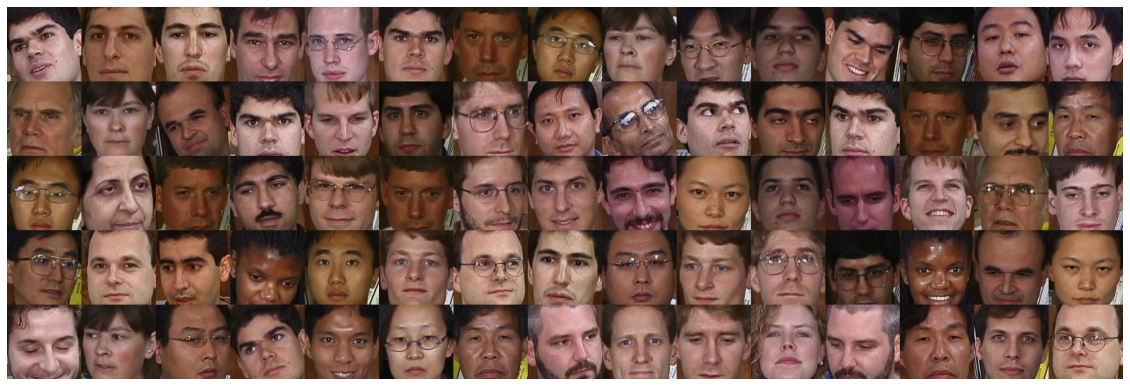

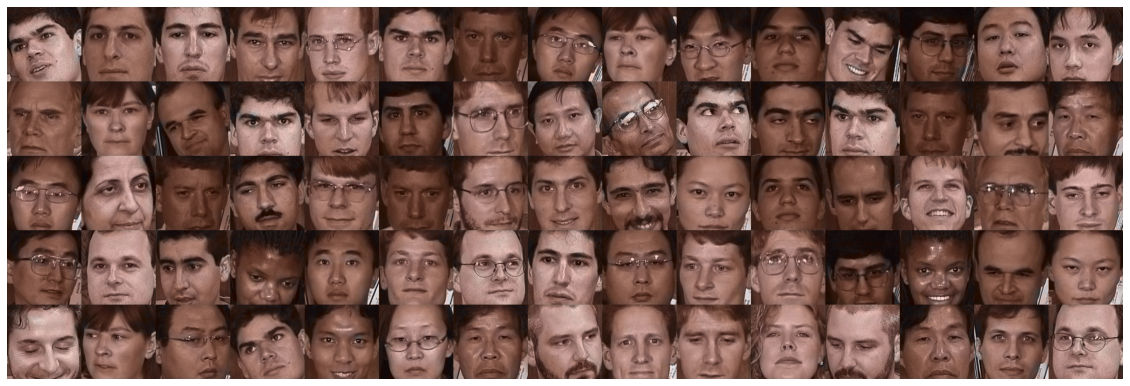

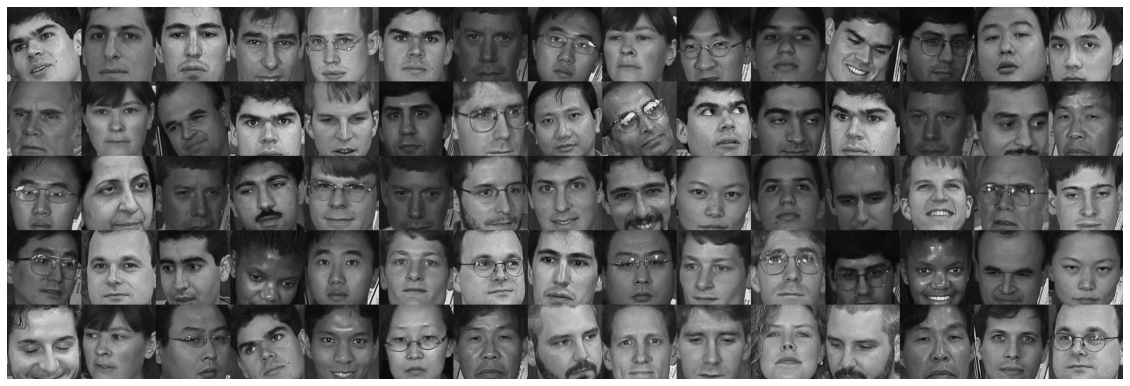

In [8]:
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(testLoader, 0):
        #inputs, labels = data[0].cuda(), data[1].cuda() #Reg
        inputs, labels = data[0].cuda(), data[2].cuda() #Color
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        # print statistics
        test_loss += loss.item()
        saveRes2Img(inputs, labels, outputs)        
    n_samples = (i+1)*len(outputs)       

logStr = 'Test MSE of the network on the %d test samples: %.10f' % (n_samples, test_loss/(i+1))
trainTestLog.write(logStr+'\n') #Save training records into log.
print(logStr)
trainTestLog.close() 